<h2>Script TP2</h2>
<h3>Assumptions Check</h3>
<h3>Path analysis</h3>
<br> (c) Marie-Eve Picard, Maude Picard, Andreanne Proulx

<h3>Path analysis</h3>
<h4>Normality, multicollinearity, singularity</h4>

In [68]:
#import required modules
import pandas as pd 
import numpy as np
import scipy
import scipy.stats as stats
import math
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline
import seaborn as sn
import statsmodels.api as sm
from sklearn import preprocessing

import biokit
from biokit.viz import corrplot
import seaborn as sns
from biokit.viz import heatmap
import dcor
import copy
import graphviz

import semopy
from semopy import Model
from semopy import semplot
import graphviz
from graphviz import Digraph
from graphviz import Graph
from graphviz import escape
import semopy

In [69]:
#set pandas option so that we can see the entire dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

<b>Import the dataset</b>

In [70]:
#df = pd.read_spss("C:/Users/mepic/OneDrive/Documents/Master/PSY6002/TP/TP2/PSY6002_Cannabis_removeLabels.sav")
df = pd.read_csv("data_tp2.csv", sep= ";")

## Prepare data

- Remove demographic variables
- Regroup variables T1, T2, T3

In [71]:
#Variables to exclude
ls_excluded = ['respid','status','l','version','dwave','Consent','XAge','Birth','XBirth','Mom_Nat','XMom_Nat', 'Pop_Nat', 'XPop_Nat', 'Country', 'Province','City','XCity','Language','XLanguage','French','English','Nationality','CanNat','OtherNat','Can_Qc','Diploma','Situation','FinalComments','ConsentT2','FinalCommentsT2','ConsentT3','FinalCommentT3','oldq1','oldl','oldhq2','oldq9','oldCountryBirth','oldMotherBirth','oldDadBirth','oldCountry','oleProvince','OldNationality','oleDiploma','oldq11','IdenGroupT2','oldAge', 'IdenGroupT3']
df = df.drop(ls_excluded, axis = 1)

In [72]:
#Regroup variables with a spectific substring in the name
def regroupVar(substr=None, liste=None):
    subs = substr
    res = [i for i in liste if subs in i]
    return res


columns_T2 = regroupVar(substr = 'T2', liste = df.columns)
columns_T3 = regroupVar(substr = 'T3', liste = df.columns)

In [73]:
#Create new Dataframes with variables at different times (T1, T2, T3)
df_T1 = df.drop(columns_T2+columns_T3, axis = 1)
df_T2 = df.filter(items = columns_T2)
df_T3 = df.filter(items = columns_T3)

In [74]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety'],
      dtype='object')

<h3><b>Transform Userstatus variable in a dichotomous variable</h3></b>
<br> 0 = jamais consommé (category included: Non-consommateur)
<br>1 = déjà consommé (categories included: Ex-consommateur, Expérimentateur, Occasionnel, Régulier)

In [75]:
df_T1['UserBin'] = ""
for i in range(len(df_T1['Userstatus'])):
    if df_T1['Userstatus'][i] == 1.0:
        df_T1['UserBin'][i] = 0
    else:
        df_T1['UserBin'][i] = 1

df_T1['UserBin'] = df_T1['UserBin'].astype('category')

/home/anproulx/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/anproulx/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<h3><b>Compute variables</h3></b>

<b>Compute the Attitude variable (T1)</b>
<br>reverse attitude items and compute the mean

In [76]:
#Create dataframe with only variables from prejudice scale
att_scale_T1 = df_T1.filter(items = ['Attitude_2','Attitude_3','Attitude_4'])

In [77]:
#Create a function to reverse the score
def inversed_score(dataframe = None, high = None):
    dataframe_dummy = dataframe.copy()
    for i in range(len(dataframe_dummy.columns)):
        for j in range (len(dataframe_dummy[dataframe_dummy.columns[0]])):
            dataframe_dummy[dataframe_dummy.columns[i]][j] = high - dataframe_dummy[dataframe_dummy.columns[i]][j]

    return dataframe_dummy

In [78]:
#Reverse Echelle de prejuges
att_scale_T1_inversed = inversed_score(dataframe = att_scale_T1, high = 4)

In [79]:
#Compute the mean of items in Echelle de prejuges (items 19 a 22)
df_T1["prejuges"] = att_scale_T1_inversed.mean(axis=1, skipna=False)

In [80]:
def compute_mean(dataframe=None, cols = None, col_name = None):
    dataframe[col_name] = dataframe[cols].mean(axis = 1)

    return dataframe

In [81]:
# string -> float 
columns = df_T1.columns
for column in columns:
    if type(df_T1[column][0]) == str:
        
        df_T1[column] = df_T1[column].apply(lambda x: str(x.replace(',','.')))
        df_T1[column]= pd.to_numeric(df_T1[column], errors='coerce')

df_T1.head()

,Gender,Age,life_cond,left_right,change_trad,Freqnow,Userstatus,Legal,Illegal,Quantity,Frequency,Attitude_2,Attitude_3,Attitude_4,GQuantity,GFrequency,Neg_Pos,AffectPerso,AffectGroup,Rapid_slow,Few_Many,Small_Big,Comp_1,Comp_2,Cat,Int_2,Int_3,Int_4,IdentifyPot,CommonPot,ImpPot,Moi_Pot,GComp_1,GComp_2,GCat,GInt_2,GInt_3,GInt_4,GIdentifyPot,GcommonPot,GImpPot,Can_Pot,Qc_Pot,SuiviPot,Clarity_2,Clarity_3,Coherence_1,Coherence_3,Coherence_4,Belong_1,Belong_2,Belong_3,Safety_1,Safety_2,Safety_3,Comp,GComp,IdenPot,GIdenPot,Attitudes,Int,GInt,Clarity,Coherence,Belong,Safety,UserBin,prejuges
0,1,55.0,2,2,4,1,1,0,0,2,2,3,3,2,4,4,0,3,3,3,1,4,3,2,4,2,2,2,0,0,0,1,4,2,2,2,2,2,2,2,2,1,1,4,2,2,2,2,2,4,2,4,4,3,3,2.5,3.0,0.0,2.000000,2.666667,2.000000,2.0,2.0,2.000000,3.333333,3.333333,0,1.333333
1,2,71.0,3,2,3,1,1,2,0,1,1,0,1,1,3,3,2,2,3,3,2,2,2,2,1,0,0,0,0,0,0,1,3,3,3,0,0,0,1,2,0,1,1,2,3,3,3,1,2,4,3,4,4,4,4,2.0,3.0,0.0,1.000000,0.666667,0.000000,0.0,3.0,2.000000,3.666667,4.000000,0,3.333333
2,2,37.0,2,2,3,1,1,0,0,2,2,1,3,3,4,4,2,1,2,1,2,2,2,4,4,4,4,4,0,0,0,1,3,3,3,3,3,3,3,3,1,4,7,0,1,2,2,3,2,4,4,4,4,4,4,3.0,3.0,0.0,2.333333,2.333333,4.000000,3.0,1.5,2.333333,4.000000,4.000000,0,1.666667
3,2,66.0,2,2,2,1,3,0,0,2,2,2,4,2,4,4,1,0,0,0,3,2,0,2,4,3,3,2,0,0,0,1,4,4,4,1,1,1,2,2,0,1,1,2,1,3,1,1,0,2,2,3,3,3,3,1.0,4.0,0.0,1.333333,2.666667,2.666667,1.0,2.0,0.666667,2.333333,3.000000,1,1.333333
4,2,53.0,1,2,2,1,1,2,2,2,2,2,2,2,2,2,2,1,3,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.000000,0,2.000000


In [82]:
#Compute perception du changement social (items 27,28,29,29)
df_T1 = compute_mean(dataframe = df_T1, cols = ['AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big'], col_name = 'perc_soc')
#Compute clarity and coherence (items 46 a 52)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Clarity','Coherence'], col_name = 'clar_co')
#Compute Besoin (items 53  a 60)
df_T1 = compute_mean(dataframe = df_T1, cols = ['Belong','Safety'], col_name = 'need')
#Compute perception (items 23, 24)
df_T1 = compute_mean(dataframe = df_T1, cols = ['GQuantity', 'GFrequency'], col_name = 'perception')

In [83]:
df_T1.columns

Index(['Gender', 'Age', 'life_cond', 'left_right', 'change_trad', 'Freqnow',
       'Userstatus', 'Legal', 'Illegal', 'Quantity', 'Frequency', 'Attitude_2',
       'Attitude_3', 'Attitude_4', 'GQuantity', 'GFrequency', 'Neg_Pos',
       'AffectPerso', 'AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big',
       'Comp_1', 'Comp_2', 'Cat', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot',
       'CommonPot', 'ImpPot', 'Moi_Pot', 'GComp_1', 'GComp_2', 'GCat',
       'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot',
       'Can_Pot', 'Qc_Pot', 'SuiviPot', 'Clarity_2', 'Clarity_3',
       'Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2',
       'Belong_3', 'Safety_1', 'Safety_2', 'Safety_3', 'Comp', 'GComp',
       'IdenPot', 'GIdenPot', 'Attitudes', 'Int', 'GInt', 'Clarity',
       'Coherence', 'Belong', 'Safety', 'UserBin', 'prejuges', 'perc_soc',
       'clar_co', 'need', 'perception'],
      dtype='object')

<b>Create a dataframe with the computed variables</b>

In [84]:
ls_excluded_T1 = ['Attitude_2','Attitude_3', 'Attitude_4', 'Attitudes','GQuantity','GFrequency','AffectGroup', 'Rapid_slow', 'Few_Many', 'Small_Big', 'Comp_1', 'Comp_2', 'Int_2', 'Int_3', 'Int_4', 'IdentifyPot','CommonPot', 'ImpPot', 'GComp_1', 'GComp_2', 'GInt_2', 'GInt_3', 'GInt_4', 'GIdentifyPot', 'GcommonPot', 'GImpPot', 'Clarity_2', 'Clarity_3','Coherence_1', 'Coherence_3', 'Coherence_4', 'Belong_1', 'Belong_2','Belong_3', 'Safety_1', 'Safety_2', 'Safety_3','Clarity','Coherence', 'Belong', 'Safety']

In [85]:
df_T1 = df_T1.drop(ls_excluded_T1, axis = 1)

In [86]:
#Change type of categorical variables (now they are consider as continuous variables)
df_T1['Freqnow'] = df_T1['Freqnow'].astype('category')
df_T1['Userstatus'] = df_T1['Userstatus'].astype('category')
df_T1['Legal'] = df_T1['Legal'].astype('category')
df_T1['Illegal'] = df_T1['Illegal'].astype('category')
df_T1['Quantity'] = df_T1['Quantity'].astype('category')
df_T1['Frequency'] = df_T1['Frequency'].astype('category')

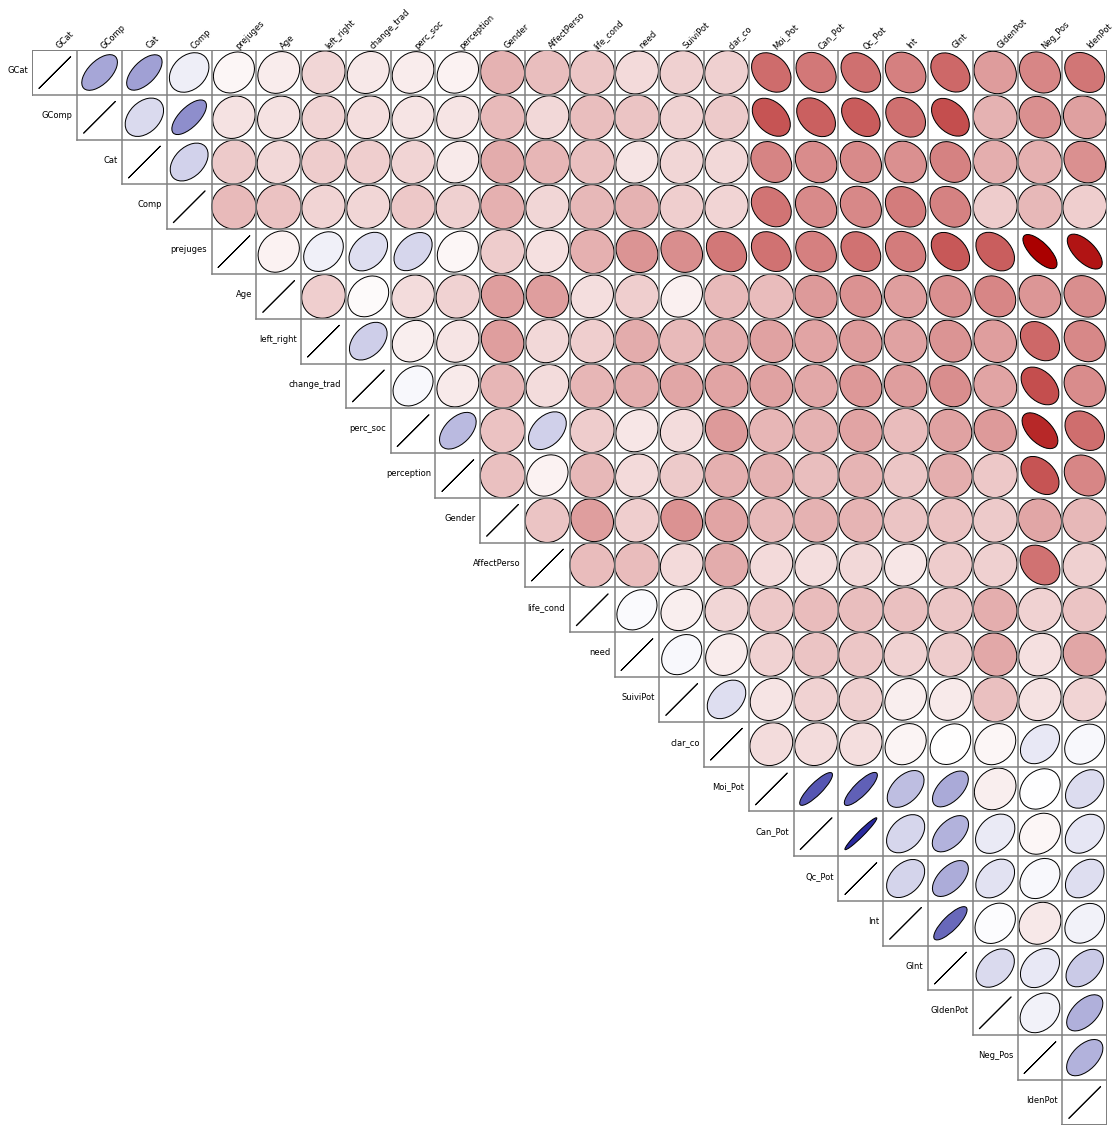

In [87]:
corr_matrix = df_T1.corr(method = 'pearson')
c = corrplot.Corrplot(corr_matrix)

c.plot(colorbar=False, method='text',shrink= 1 ,rotation=45, upper = "ellipse")
fig = plt.gcf()
fig.set_size_inches(20, 20)

<h2><b>Model Choice</h2></b>
<br>Variables included in the model: 

<li> perception: endogene </li>
<li>IdenPot : exogene</li>
<li>préjugés : exogene</li>
<li>Neg_pos : médiatrice </li>

In [91]:
#data = df_T1[["GInt", "Neg_Pos", "IdenPot", "att_mean"]]

df_model = df_T1.filter(items = ['Neg_Pos','prejuges','IdenPot','perception'])

### Sample moments

In [95]:
## Sample correlation
data = df_model
mx_cor_initial = df_model.corr()

print ("Matrice de corrélations initiales \n \n" + str(mx_cor_initial))

Matrice de corrélations initiales 
 
             Neg_Pos  prejuges   IdenPot  perception
Neg_Pos     1.000000 -0.596017  0.440847   -0.331633
prejuges   -0.596017  1.000000 -0.531984    0.173048
IdenPot     0.440847 -0.531984  1.000000   -0.177226
perception -0.331633  0.173048 -0.177226    1.000000


In [96]:
# calculates the covariance between x and y 
def calcCov(x, y): 
  
    mean_x, mean_y = x.mean(), y.mean() 
    n = len(x) 
  
    return sum((x - mean_x) * (y - mean_y)) / n 
  
  
# computes the Covariance matrix 
def covMat(data): 
  
    # get the rows and cols 
    rows, cols = data.shape 
  
    # the covariance matroix has a shape of n_features x n_features 
    # n_featurs  = cols - 1 (not including the target column) 
    cov_mat = np.zeros((cols, cols)) 
  
    for i in range(cols): 
  
        for j in range(cols): 
            # store the value in the matrix 
            cov_mat[i][j] = calcCov(data[:, i], data[:, j]) 
  
    return cov_mat 
  
mx_cov_initial = pd.DataFrame(covMat(np.array(data)))
mx_cov_initial.columns=data.columns
mx_cov_initial.index=data.columns

print ("Matrice de covariance initiales \n \n" + str(mx_cov_initial))

Matrice de covariance initiales 
 
             Neg_Pos  prejuges   IdenPot  perception
Neg_Pos     1.461409 -0.844147  0.459268   -0.361794
prejuges   -0.844147  1.372612 -0.537113    0.182960
IdenPot     0.459268 -0.537113  0.742652   -0.137828
perception -0.361794  0.182960 -0.137828    0.814394


In [97]:
# compare 
mx_cov_initial_npy = data.cov()
print(mx_cov_initial_npy)

             Neg_Pos  prejuges   IdenPot  perception
Neg_Pos     1.462279 -0.844649  0.459541   -0.362009
prejuges   -0.844649  1.373428 -0.537432    0.183069
IdenPot     0.459541 -0.537432  0.743094   -0.137910
perception -0.362009  0.183069 -0.137910    0.814879


### First model

In [128]:
# First model

# specify model
desc = '''
Neg_Pos ~ IdenPot 
Neg_Pos ~ prejuges
perception ~ Neg_Pos
prejuges ~ prejuges
IdenPot ~ IdenPot
'''

#Neg_Pos ~~ IdenPot


In [129]:
m = semopy.Model(desc) 
res = m.fit(data) #  obj = "FIML")# specifies maximum likelihood

In [130]:
print(res) 

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.337
Number of iterations: 10
Params: 0.242 -0.520 -0.248 0.155 -0.089 0.911 0.980 0.725 0.880


In [131]:
# code adapted from semopy documentation
# https://semopy.com/docs/plot.html

def semplot_wth_estimates(mod: Model, filename: str, inspection=None, plot_covs=False,
            plot_exos=True, images=None, engine='dot', latshape='circle',
            show=False):
    """
    Draw a SEM diagram """
    
   
    if inspection is None:
        inspection = mod.inspect()
    if images is None:
        images = dict()
    t = filename.split('.')
    filename, ext = '.'.join(t[:-1]), t[-1]
    g = graphviz.Digraph('G', format=ext, engine=engine)
    
    g.attr(overlap='scale', splines='true')
    g.attr('edge', fontsize='12')
    g.attr('node', shape=latshape, fillcolor='lightblue2', style='filled')
    
    for lat in mod.vars['latent']:
        if lat in images:
            g.node(lat, label='', image=images[lat])
        else:
            g.node(lat, label=lat)
    
    g.attr('node', shape='ellipse', style='')
    
    for obs in mod.vars['observed']:
        if obs in images:
            g.node(obs, label='', image=images[obs])
    
        else:
            g.node(obs, label=obs)
    
    g.edge("err1", "perception", len='0.15')
    g.edge("err2", "Neg_Pos", len='0.15')
    g.node('err1', shape='circle')
    g.node('err2', shape='circle')
    
    #variance 
    #g.edge('LR_5', 'LR_5', label='S(a)')         

    regr = inspection[inspection['op'] == '~']
    all_vars = mod.vars['all']
    try:
        exo_vars = mod.vars['observed_exogenous']
    except KeyError:
        exo_vars = set()
    for _, row in regr.iterrows():
        lval, rval = row['lval'], row['rval']
        if (rval not in all_vars) or (~plot_exos and rval in exo_vars) or\
            (rval == '1'):
            continue
        g.edge(rval, lval)
        
        #if (rval not in all_vars) or (~plot_exos and rval in mod.vars['observed']) or\
        #    (rval == '1'):
        #    continue

        #g.edge (rval, lval)
        
    if plot_covs:
        covs = inspection[inspection['op'] == '~~']
        for _, row in covs.iterrows():
            lval, rval = row['lval'], row['rval']
            if lval == rval:
                continue
            g.edge(rval, lval, dir='both', style='dashed')
    g.render(filename, view=show)
    return g



def semplot_with_estimates(mod: Model, filename: str, inspection=None, plot_covs=False,
            plot_exos=True, images=None, engine='dot', latshape='circle',
            show=False):
    """
    Draw a SEM diagram.

    """
   
    if inspection is None:
        inspection = mod.inspect()
    if images is None:
        images = dict()
    t = filename.split('.')
    filename, ext = '.'.join(t[:-1]), t[-1]
    g = graphviz.Digraph('G', format=ext, engine=engine)
    
    g.attr(overlap='scale', splines='true')
    g.attr('edge', fontsize='12')
    g.attr('node', shape=latshape, fillcolor='#cae6df', style='filled')
    for lat in mod.vars['latent']:
        if lat in images:
            g.node(lat, label='', image=images[lat])
        else:
            g.node(lat, label=lat)
    
    g.attr('node', shape='ellipse', style='')
    for obs in mod.vars['observed']:
        if obs in images:
            g.node(obs, label='', image=images[obs])
        else:
            g.node(obs, label=obs)

    regr = inspection[inspection['op'] == '~']
    all_vars = mod.vars['all']
    try:
        exo_vars = mod.vars['observed_exogenous']
    except KeyError:
        exo_vars = set()
    for _, row in regr.iterrows():
        lval, rval, est = row['lval'], row['rval'], row['Estimate']
        if (rval not in all_vars) or (~plot_exos and rval in exo_vars) or\
            (rval == '1'):
            continue
        pval = row['p-value']
        label = '{:.3f}'.format(float(est))
        if pval !='-':
            label += r'\np-val: {:.2f}'.format(float(pval))
        g.edge(rval, lval, label=label)
    if plot_covs:
        covs = inspection[inspection['op'] == '~~']
        for _, row in covs.iterrows():
            lval, rval, est = row['lval'], row['rval'], row['Estimate']
            if lval == rval:
                continue
            pval = row['p-value']
            label = '{:.3f}'.format(float(est))
            if pval !='-':
                label += r'\np-val: {:.2f}'.format(float(pval))
            g.edge(rval, lval, label=label, dir='both', style='dashed')
    g.render(filename, view=show)
    return g

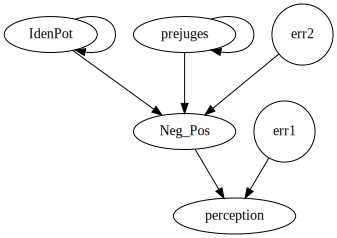

In [132]:
semplot_wth_estimates(m, "pd.png", plot_covs =True)

# Il aurait été bien que les termes d'erreurs

### Evaluate solution
- Indices d'ajustement : **SRMR**, RMSEA, CFI, X2, **correlation residuals, covariance residuals std**
- Paramètres : B, pval, **R2, % de variance expliquée /non-expliquée**


- SPSS: indices de modification

In [133]:
# Indice d'ajustements
stats = semopy.calc_stats(m)
print(stats.T)

                     Value
DoF               1.000000
DoF Baseline      6.000000
chi2            566.023175
chi2 p-value      0.000000
chi2 Baseline  1556.861876
CFI               0.635672
GFI               0.636433
AGFI             -1.181400
NFI               0.636433
TLI              -1.185971
RMSEA             0.579761
AIC              17.326964
BIC              66.176614
LogLik            0.336518


In [134]:
# paramètres
results = m.inspect(std_est = True)
results

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,Neg_Pos,~,IdenPot,0.242447,0.181426,0.027002,8.978778,0.000000e+00
1,Neg_Pos,~,prejuges,-0.520434,-0.529480,0.019861,-26.203990,0.000000e+00
2,prejuges,~,prejuges,0.155015,0.155015,0.012285,12.617871,0.000000e+00
3,IdenPot,~,IdenPot,-0.088563,-0.088563,0.013574,-6.524302,6.831913e-11
4,perception,~,Neg_Pos,-0.247776,-0.317786,0.018026,-13.745649,0.000000e+00
5,Neg_Pos,~~,Neg_Pos,0.910646,0.686736,0.031402,29.000000,0.000000e+00
6,prejuges,~~,prejuges,0.979998,0.714000,0.005296,185.030683,0.000000e+00
7,IdenPot,~~,IdenPot,0.879900,1.184970,0.008397,104.790884,0.000000e+00
8,perception,~~,perception,0.724725,0.899012,0.024991,29.000000,0.000000e+00


In [140]:
# % de variance non-expliquée = r2
# % de variance expliquée = 1 - % de variance non-expliquée
# R2 : beta std au carré??
# Neg_pos non-expliqué = terme d'erreur std  (Est. Std)

perception_not_explained = results["Est. Std"][8]
perception_explained = (1- perception_not_explained)*100

Negpos_not_explained =results["Est. Std"][5]
Negpos_explained = (1- Negpos_not_explained)*100

print ("The model explains {}% of neg_pos (endogeneous) and {}% of GInt (endogeneous).".format(Negpos_explained, perception_explained))

The model explains 31.326408551781626% of neg_pos (endogeneous) and 10.098804257164417% of GInt (endogeneous).


In [127]:
parameter = m.parameters  ### b = beta ; c = covariance

#for par in parameter.keys():
#    print("\n" + par)
#    print(parameter[par])

In [141]:
dict_matrix = m.inspect("mx", std_est = True)
for key in dict_matrix.keys():
    print("\n" + key)
    print(pd.DataFrame(dict_matrix[key]))
    
# lambda: estimates bêta
# Psi: estimates covariance
# Theta : esimates termes erreurs


Beta
           IdenPot  Neg_Pos  prejuges
IdenPot  -0.088563      0.0  0.000000
Neg_Pos   0.242447      0.0 -0.520434
prejuges  0.000000      0.0  0.155015

Lambda
            IdenPot   Neg_Pos  prejuges
perception      0.0 -0.247776       0.0
IdenPot         1.0  0.000000       0.0
Neg_Pos         0.0  1.000000       0.0
prejuges        0.0  0.000000       1.0

Psi
          IdenPot   Neg_Pos  prejuges
IdenPot    0.8799  0.000000  0.000000
Neg_Pos    0.0000  0.910646  0.000000
prejuges   0.0000  0.000000  0.979998

Theta
            perception  IdenPot  Neg_Pos  prejuges
perception    0.724725      0.0      0.0       0.0
IdenPot       0.000000      0.0      0.0       0.0
Neg_Pos       0.000000      0.0      0.0       0.0
prejuges      0.000000      0.0      0.0       0.0


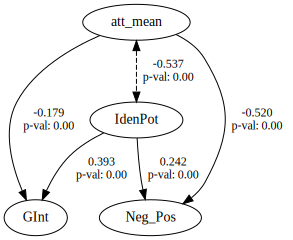

In [44]:
g_model = semplot_with_estimates(m, "pd.png", plot_covs = True)
g_model

#### Covariances résiduelles

In [142]:
# matrix covariance finale
mx_cov_final = m.mx_cov
print(" Matrix covariance finale : \n" +  str(mx_cov_final))

# sur AMOS =0.331069 , ici c'est plutôt =0.41114705  (GInt, Neg_Pos) -> pourquoi cette discordance...

 Matrix covariance finale : 
[[ 0.81439423 -0.137828   -0.36179362  0.1829604 ]
 [-0.137828    0.74265238  0.45926819 -0.53711286]
 [-0.36179362  0.45926819  1.46140926 -0.84414728]
 [ 0.1829604  -0.53711286 -0.84414728  1.37261192]]


In [143]:
# matrix residual covariance
mx_res_cov = (mx_cov_initial - mx_cov_final).abs()
print(" Matrix covariances résiduelles : \n \n" +  str(mx_res_cov))


 Matrix covariances résiduelles : 
 
             Neg_Pos  prejuges   IdenPot  perception
Neg_Pos     0.647015  0.706319  0.821062    0.544754
prejuges    0.706319  0.629960  0.996381    0.720073
IdenPot     0.821062  0.996381  0.718757    0.706319
perception  0.544754  0.720073  0.706319    0.558218


In [144]:
# matrix standard residual covariances
dim = 4
cov_1d = np.array(mx_res_cov).flatten()

# std residuals
std_cov_1d = np.std(cov_1d)
mx_std = [[std_cov_1d]*dim]*dim

# mean residuals
mean_cov_1d = np.mean(cov_1d)
mx_mean = [[mean_cov_1d]*dim]*dim

std_res_cov = (mx_res_cov - mx_mean).abs()/ mx_std
print(" Matrix covariances résiduelles std : \n \n" +  str(std_res_cov))

 Matrix covariances résiduelles std : 
 
             Neg_Pos  prejuges   IdenPot  perception
Neg_Pos     0.568095  0.115694  0.759615    1.348190
prejuges    0.115694  0.698202  2.097032    0.010773
IdenPot     0.759615  2.097032  0.020815    0.115694
perception  1.348190  0.010773  0.115694    1.245482


In [145]:
# Devrait être < que 2: pass for all values. Ici seulement GInt, GInt est > 2. On observe des discordances avec amos, mais j'ai l'impression que c'est uniquement une question de précision. + le fait que plus haut on obtiens 0,41 au lieu de 0,33. 

In [146]:
# matrix of residuals correlation

# std for each variable
std_variables = np.array(data.std(axis = 0))

# recover correlation matrix from covariance matrix
def corrMat(data): 
    rows, cols = data.shape 
    corr_mat = np.zeros((cols, cols)) 
  
    for i in range(cols): 
        for j in range(cols): 
  
            x, y = data[:, i], data[:, j] 
            # not here that we are just normalizing the covariance matrix 
            corr_mat[i][j] = data[i][j] / (std_variables[i] * std_variables[j]) 
  
    return corr_mat 


#test to see if we get initial correlation matrix from covariance matrix
mx_cor_initial = corrMat(np.array(mx_cov_initial_npy))
mx_cor_initial

print("This is the recovered initial correlation matrix. \n \n" + str(mx_cor_initial))

This is the recovered initial correlation matrix. 
 
[[ 1.         -0.59601668  0.44084676 -0.33163292]
 [-0.59601668  1.         -0.53198438  0.17304772]
 [ 0.44084676 -0.53198438  1.         -0.17722595]
 [-0.33163292  0.17304772 -0.17722595  1.        ]]


In [147]:
# matrice de corrélations finales 
mx_cor_final = corrMat(np.array(mx_cov_final))
mx_cor_final

print("Matrice des corrélations finales: \n \n" + str(mx_cor_final))

# precision is not the same as in Amos


Matrice des corrélations finales: 
 
[[ 0.55693505 -0.09725666 -0.34707546  0.16760831]
 [-0.09725666  0.54072884  0.45461255 -0.50771039]
 [-0.34707546  0.45461255  1.96665418 -1.08480035]
 [ 0.16760831 -0.50771039 -1.08480035  1.68443712]]


In [151]:
# matrice de corrélations des résiduelles
# recovering correlation residuals with the function corrMat

print ("Recovered correlation matrix residuals from residual covariance using corrMat function \n \n" + str(np.array(mx_res_cov)))

Recovered correlation matrix residuals from residual covariance using corrMat function 
 
[[0.64701503 0.70631928 0.82106181 0.54475402]
 [0.70631928 0.62995954 0.99638105 0.72007326]
 [0.82106181 0.99638105 0.71875688 0.70631928]
 [0.54475402 0.72007326 0.70631928 0.5582177 ]]


### Alternative model

- Différence X2
- Comparer ajustements
- Vérifier la force du lien ajouté

In [155]:
# Alternative model
# specify model : add coariance btw endogenous variables

m2 = '''
Neg_Pos ~ IdenPot 
Neg_Pos ~ prejuges
perception ~ Neg_Pos
IdenPot ~~ prejuges
prejuges ~~ prejuges
IdenPot ~~ IdenPot

'''

In [156]:
m2 = semopy.Model(m2) 
res = m2.fit(data) #, obj = "FIML")# specifies maximum likelihood
print(res)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 0.004
Number of iterations: 9
Params: 0.242 -0.520 -0.248 -0.537 0.743 1.373 0.911 0.725


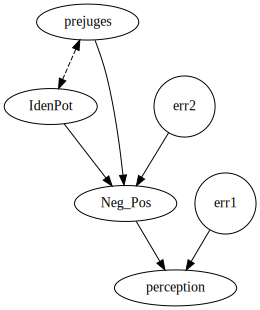

In [157]:
semplot_wth_estimates(m2, "model2.png", plot_covs =True)

In [158]:
# Indice d'ajustements
stats = semopy.calc_stats(m2)
print(stats.T)

                     Value
DoF               2.000000
DoF Baseline      6.000000
chi2              6.438606
chi2 p-value      0.039983
chi2 Baseline  1556.861860
CFI               0.997138
GFI               0.995864
AGFI              0.987593
NFI               0.995864
TLI               0.991414
RMSEA             0.036335
AIC              15.992344
BIC              59.414255
LogLik            0.003828


In [164]:
# Pourquoi chi-carré pas le même ... AMOS = 0,000000003

In [159]:
# paramètres
results = m2.inspect(std_est = True)
results

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,Neg_Pos,~,IdenPot,0.242034,0.172563,0.031890,7.589632,3.197442e-14
1,Neg_Pos,~,prejuges,-0.520175,-0.504197,0.023457,-22.175557,0.000000e+00
2,perception,~,Neg_Pos,-0.247740,-0.331769,0.017176,-14.423537,0.000000e+00
3,IdenPot,~~,prejuges,-0.537113,-0.531984,0.027885,-19.261819,0.000000e+00
4,IdenPot,~~,IdenPot,0.742652,1.000000,0.025609,29.000000,0.000000e+00
5,prejuges,~~,prejuges,1.372612,1.000000,0.047331,29.000000,0.000000e+00
6,Neg_Pos,~~,Neg_Pos,0.910833,0.623436,0.031408,29.000000,0.000000e+00
7,perception,~~,perception,0.724970,0.889929,0.024999,29.000000,0.000000e+00


In [161]:
Gint_not_explained = results["Est. Std"][6]
Gint_explained = (1- Gint_not_explained)*100

Negpos_not_explained =results["Est. Std"][7]
Negpos_explained = (1- Negpos_not_explained)*100

print ("The model explains {}% of neg_pos (endogeneous) and {}% of GInt (endogeneous).".format(Negpos_explained, Gint_explained))

The model explains 11.007099896887285% of neg_pos (endogeneous) and 37.65636082768261% of GInt (endogeneous).


In [162]:
dict_matrix = m2.inspect("mx", std_est = True)
for key in dict_matrix.keys():
    print("\n" + key)
    print(pd.DataFrame(dict_matrix[key]))


Beta
           IdenPot  Neg_Pos  prejuges
IdenPot   0.000000      0.0  0.000000
Neg_Pos   0.242034      0.0 -0.520175
prejuges  0.000000      0.0  0.000000

Lambda
            IdenPot  Neg_Pos  prejuges
perception      0.0 -0.24774       0.0
IdenPot         1.0  0.00000       0.0
Neg_Pos         0.0  1.00000       0.0
prejuges        0.0  0.00000       1.0

Psi
           IdenPot   Neg_Pos  prejuges
IdenPot   0.742652  0.000000 -0.537113
Neg_Pos   0.000000  0.910833  0.000000
prejuges -0.537113  0.000000  1.372612

Theta
            perception  IdenPot  Neg_Pos  prejuges
perception     0.72497      0.0      0.0       0.0
IdenPot        0.00000      0.0      0.0       0.0
Neg_Pos        0.00000      0.0      0.0       0.0
prejuges       0.00000      0.0      0.0       0.0


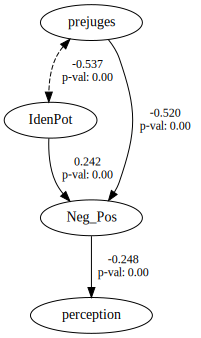

In [163]:
g_model = semplot_with_estimates(m2, "pd.png", plot_covs = True)
g_model

In [164]:
m2.mx_cov

array([[ 0.81439423, -0.137828  , -0.36179362,  0.1829604 ],
       [-0.137828  ,  0.74265238,  0.45926819, -0.53711286],
       [-0.36179362,  0.45926819,  1.46140926, -0.84414728],
       [ 0.1829604 , -0.53711286, -0.84414728,  1.37261192]])

In [165]:
# mx covariance final
m2_mx_cov_final = m2.mx_cov

# matrix residual covariance
m2_mx_res_cov = (mx_cov_initial - m2_mx_cov_final).abs()
print ("Matrix covariance residuals")
pd.DataFrame(m2_mx_res_cov, columns =data.columns, index =data.columns)

Matrix covariance residuals


,Neg_Pos,prejuges,IdenPot,perception
Neg_Pos,0.647015,0.706319,0.821062,0.544754
prejuges,0.706319,0.629960,0.996381,0.720073
IdenPot,0.821062,0.996381,0.718757,0.706319
perception,0.544754,0.720073,0.706319,0.558218


In [166]:
m2_cov_1d= np.array(m2_mx_res_cov).flatten()
m2_cov_1d

dim = 4

# std cov residuals
m2_std_cov_1d = np.std(m2_cov_1d)
m2_mx_std = [[m2_std_cov_1d]*dim]*dim

# std mean residuals
m2_mean_cov_1d = np.mean(m2_cov_1d)
m2_mx_mean = [[m2_mean_cov_1d]*dim]*dim

print("Matrix covariance residuals std")
m2_std_res_cov = (m2_mx_res_cov - m2_mx_mean).abs()/ m2_mx_std
m2_std_res_cov

Matrix covariance residuals std


,Neg_Pos,prejuges,IdenPot,perception
Neg_Pos,0.568095,0.115694,0.759615,1.348190
prejuges,0.115694,0.698202,2.097032,0.010773
IdenPot,0.759615,2.097032,0.020815,0.115694
perception,1.348190,0.010773,0.115694,1.245482


In [167]:
print("Matrice residual correlation recovered from covariance residuals with function corrMat")
corrMat(np.array(m2_mx_res_cov))

Matrice residual correlation recovered from covariance residuals with function corrMat


array([[0.44247042, 0.49840567, 0.78766012, 0.49904406],
       [0.49840567, 0.45867663, 0.98628065, 0.68065522],
       [0.78766012, 0.98628065, 0.96724871, 0.90767976],
       [0.49904406, 0.68065522, 0.90767976, 0.68503165]])